# Métodos de Computação Quântica com o Atos QLM

O ATOS Quantum Learning Machine (QLM) é um ambiente de teste para a computação quântica desenvolvida pela empresa francesa ATOS e adquirida pelo SENAI CIMATEC para o desenvolvimento de algoritmos quânticos no Centro de Computação Quântica da América Latina. O dispositivo é capaz de simular até 35 qubits e inclui a simulação de ruídos, emulando a arquitetura de computadores quânticos reais.

O QLM também possui interoperabilidade com outras frameworks de computação quântica, o que possibilita o uso de computadores quânticos através da plataforma. Além disso, o myQLM, framework disponibilizado gratuitamente, possibilita também o desenvolvimento e simulação de algoritmos quânticos por usuários domésticos, podendo sker instalado em seus computadores. Por sua completeza, a utilização do QLM para o desenvolvimento de algoritmos de computação quântica se torna interessante, podendo ser utilizado em diferentes etapas do desenvolvimento de algoritmos quânticos.

In [1]:
import scipy
import matplotlib.pyplot as plt
from qat.lang.AQASM import Program, CNOT, H, RY, RZ  # , RX
from qat.qpus import get_default_qpu
import numpy as np
# from numpy import linalg
# from qat.qpus import PyLinalg
# import qiskit
from qiskit import *
# from qiskit.aqua.components.optimizers import COBYLA,SLSQP,SPSA
# from qiskit.visualization import plot_histogram
import numpy as np
# from numpy import pi
# from scipy import optimize

%matplotlib inline


# Otimização de Portfólio

A função objetivo para a otimização de portfólio pode ser modelada como uma função quadrática binária irrestrita. 

Resolver o seguinte problema de otimização: \begin{split}\begin{aligned} \min_{x \in \{0, 1\}^n} q x^T \sigma x - \mu^T x\\ \text{com a restrição: } 1^T x = B \end{aligned}\end{split}
onde:
- $x \in \{0,1\}^n$ denota o vetor de variáveis ​​de decisão binárias, que indicam quais ativos escolher ($x = 1$) e quais não escolher ($x =0$),
- $\mu \in \mathbf{R}^n$ define os retornos esperados para os ativos, 
- $\sigma \in \mathbf{R}^{n\times n}$ especifica a matriz de covariância entre os ativos,
- $q>0$ controla o apetite de risco do gestor do portfólio,
- e $B$ denota o orçamento, neste caso, o número de ativos a serem selecionados dentre $n$ disponíveis.

Observações:

1 - simplificações assumidas: i) todos os ativos tem o mesmo preço normalizado como $1$ (pensando no log dos preços, não parece uma simplificação tão absurda), ii) o orçamento total deve ser gasto, ou seja, é necessário selecionar exatamente $B$ ativos. 

2- $q$ pode ser visto como uma medida do apetite ao risco pois, ao aumentar $q$, precisamos de maiores retornos para o alcançar o mínimo da função objetiva, o que, pela Fronteira Eficiente, exige maiores riscos!

3- A restrição $1^T x = B$ pode ser imaginada como oriunda de um termo de penalidade do tipo $\alpha (1^T x - B)^2$ incluído explicitamente na função objetiva. Ou seja, o problema com a restrição acima é idêntico à otimização do seguinte:
\begin{split}\begin{aligned} \min_{x \in \{0, 1\}^n} q x^T \sigma x - \mu^T x + \alpha (1^T x - B)^2  \end{aligned}\end{split} pois considerando $\alpha >0$, a menor contribuição do termo de regularização ocorre quando $1^T x = B$.

4- O problema resultante pode ser mapeado para um hamiltoniano cujo estado fundamental corresponde à solução ótima.

Essa secção mostra como usar o Variational Quantum Eigensolver (VQE) e o Quantum Approximate Optimization Algorithm (QAOA) para encontrar a solução ideal para um determinado conjunto de parâmetros.

## 1. Quantum Approximate Optimization Algorithm (QAOA)

In [2]:
# matriz de covariante usada no problema clássico
from pyqubo import Spin, Binary
cov = [[1.08774352e-03, 2.59532811e-04, 1.80247155e-04, 3.21724369e-04],
       [2.59532811e-04, 4.43192629e-04, 7.43211072e-05, 2.27911525e-04],
       [1.80247155e-04, 7.43211072e-05, 3.89444953e-04, 1.37915422e-04],
       [3.21724369e-04, 2.27911525e-04, 1.37915422e-04, 8.75437564e-04]]

# retornos
mu = [0.31542042, 0.0571331, 0.11430001, 0.30109367]

# parâmetros da função objetiva
q = 0.5
B = 2
lamb = 1

# cria as variáveis binárias
s1, s2, s3, s4 = Spin("s1"), Spin("s2"), Spin("s3"), Spin("s4")
x1, x2, x3, x4 = Binary("x1"), Binary("x2"), Binary("x3"), Binary("x4")
#
X = [x1, x2, x3, x4]

# escreve o QUBO
EN = (mu[0]*X[0] + mu[1]*X[1] + mu[2]*X[2] + mu[3]*X[3] -
      q*(cov[0][1]*X[0]*X[1] + cov[0][2]*X[0]*X[2] + cov[0][3]*X[0]*X[3] + cov[1][2]*X[1]*X[2] +
         cov[1][3]*X[1]*X[3] + cov[2][3]*X[2]*X[3]) -
      lamb*(B - X[0] - X[1] - X[2] - X[3]))

# cria o modelo e transforma de QUBO para Ising
model = EN.compile()
linear, quadratic, offset = model.to_ising()

# coeficientes que serão usados no Operador Gamma
coefs = [linear['x1'], linear['x2'], linear['x3'], linear['x4'],
         quadratic[('x1', 'x2')], quadratic[(
             'x1', 'x3')], quadratic[('x1', 'x4')],
         quadratic[('x2', 'x3')], quadratic[('x2', 'x4')], quadratic[('x3', 'x4')]]

In [3]:
# OBS: NESSA CÉLULA, O QISKIT É USADO APENAS PARA VIZUALIZAÇÃO DO CIRCUITO

num_assets = 4


def gamma_op(gamma):
    num_q = num_assets
    qc_gamma = QuantumCircuit(num_q)
    # iteration between p0 and p1

    for i in range(num_q):
        for j in range(num_q):
            if (i < j):
                qc_gamma.cx(i, j)
                qc_gamma.rz(gamma*coefs[j+4], j)
                qc_gamma.cx(i, j)
    qc_gamma.barrier()
    for i in range(num_q):
        qc_gamma.rz(coefs[i], i)

    return qc_gamma


guess = 0
gamma_op(guess).draw(fold=-1)

░ ┌─────────────┐
q_0: ──■─────────────■────■─────────────■────■──────────────────────■──────────────────────────────────────────────░─┤ Rz(0.65762) ├
     ┌─┴─┐┌───────┐┌─┴─┐  │             │    │                      │                                              ░ └┬────────────┤
q_1: ┤ X ├┤ Rz(0) ├┤ X ├──┼─────────────┼────┼──────■───────────────┼────■────■─────────────■──────────────────────░──┤ Rz(0.5285) ├
     └───┘└───────┘└───┘┌─┴─┐┌───────┐┌─┴─┐  │    ┌─┴─┐  ┌───────┐  │  ┌─┴─┐  │             │                      ░  ├────────────┤
q_2: ───────────────────┤ X ├┤ Rz(0) ├┤ X ├──┼────┤ X ├──┤ Rz(0) ├──┼──┤ X ├──┼─────────────┼────■─────────────■───░──┤ Rz(0.5571) ├
                        └───┘└───────┘└───┘┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐└───┘┌─┴─┐┌───────┐┌─┴─┐┌─┴─┐┌───────┐┌─┴─┐ ░ ┌┴────────────┤
q_3: ──────────────────────────────────────┤ X ├┤ Rz(0) ├─────────┤ X ├─────┤ X ├┤ Rz(0) ├┤ X ├┤ X ├┤ Rz(0) ├┤ X ├─░─┤ Rz(0.65046) ├
                                           └───┘└───────┘         └───┘     └───┘└───────┘└───┘└───┘└───────┘└───┘ ░ └─────────────┘

In [4]:
# IMPLEMENTAÇÃO DO CIRCUITO VARIACIONAL NO MYQLM
def var_circuit(gamma, beta, num_layers, num_qubits):
    qprog = Program()
    qubits = qprog.qalloc(num_qubits)

    # estado inicial: |+>^n
    for qubit in range(num_qubits):
        qprog.apply(H, qubits[qubit])

    for layer in range(num_layers):
        # operador gamma

        for i in range(num_qubits):
            for j in range(num_qubits):
                if (i < j):
                    qprog.apply(CNOT, qubits[i], qubits[j])
                    qprog.apply(RZ(gamma[layer]*coefs[j+4]), qubits[j])
                    qprog.apply(CNOT, qubits[i], qubits[j])
        for i in range(num_qubits):
            qprog.apply(RZ(gamma[layer]*coefs[i]), qubits[i])

        # operador beta (forma variacional: emaranhamento linear)
        for i in range(num_qubits):
            qprog.apply(RY(beta[layer]), qubits[i])
        for i in range(num_qubits-1):
            qprog.apply(CNOT, qubits[i], qubits[i+1])
        qprog.apply(CNOT, qubits[num_qubits-1], qubits[0])
        for i in range(num_qubits):
            qprog.apply(RY(beta[layer]), qubits[i])

    return qprog

In [5]:
num_assets = 4
num_qubits = num_assets
num_layers = 8
gamma_size = num_layers
beta_size = num_layers

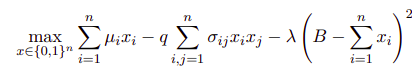

In [6]:
# ENERGIAS DO HAMILTONIANO QUE SERÃO CALCULADAS PARA OS AUTOESTADOS MEDIDOS

def energy(x):
    H = -((mu[0]*x[0]+mu[1]*x[1]+mu[2]*x[2]+mu[3]*x[3]) -
          q*(cov[0][1]*x[0]*x[1] + cov[0][2]*x[0]*x[2] +
             cov[0][3]*x[0]*x[3] + cov[1][2]*x[1]*x[2] +
             cov[1][3]*x[1]*x[3] + cov[2][3]*x[2]*x[3]) -
          lamb*(B - x[0]-x[1]-x[2]-x[3])**2)
    return H

In [7]:
energy([1, 0, 0, 1])

-0.6163532278155

In [8]:
def cost_function(param):
    circuit = var_circuit(param[:int((len(param)/2))],
                          param[(int(len(param)/2)):-1],
                          num_layers=num_layers,
                          num_qubits=num_qubits).to_circ()

    job = circuit.to_job()
    result = get_default_qpu().submit(job)
    states = []
    probs = []
    for sample in result:
        # print(sample.state, sample.probability)
        states.append(sample.state)
        probs.append(sample.probability)
    exp_value = 0
    for i in range(len(states)):
        exp_value = exp_value + energy(states[i])*probs[i]

    return exp_value

In [9]:
cost_function(np.zeros(2*num_layers+1))


0.6061766065486496

In [10]:
n = 2  # tomar a média das n melhores soluções
Hmin_med = []  # salvar a energia da solução |1001>
prob1001_med = []  # salvar a probabilidade da solução |1001>
num_seeds = 5  # tentar num_seeds soluções
num_try = 21  # fazer de 0 a (num_try-1) camadas
matriz_Hmin = []  # salvar todas as 10 energias para cada número de camadas
matriz_prob1001 = []  # salvar todas as 10 probabilidades para cada número de camadas

for k in range(num_try):
    num_layers = k
    Hmin = []
    prob1001 = []
    for i in range(num_seeds):
        np.random.seed(i**2)
        guess = np.random.random(2*num_layers+1)
        ret = scipy.optimize.minimize(cost_function, guess, args=(), method='COBYLA', constraints=(
        ), tol=None, callback=None, options={'rhobeg': 1.0, 'maxiter': 1000, 'disp': False, 'catol': 0.0002})
        Hmin.append(ret['fun'])

        check = var_circuit(ret['x'][:int(len(ret['x'])/2)],
                            ret['x'][int(len(ret['x'])/2):-1],
                            num_layers=num_layers,
                            num_qubits=num_qubits)

        circ = check.to_circ()
        job = circ.to_job()
        result = get_default_qpu().submit(job)
        states = []
        probs = []
        for sample in result:
            states.append(sample.state)
            probs.append(sample.probability)
        prob1001.append(probs[9])

    print("<H>min média dos 2 mín.:   ", np.mean(sorted(Hmin)[
          :n]), "   PROB |1001> média 3 max.:   ", np.mean(sorted(prob1001)[-n:]))
    Hmin_med.append(np.mean(sorted(Hmin)[:n]))
    prob1001_med.append(np.mean(sorted(prob1001)[-n:]))
    matriz_Hmin.append(Hmin)
    matriz_prob1001.append(prob1001)

<H>min média dos 2 mín.:    0.6061766065486496    PROB |1001> média 3 max.:    0.06249999999999996
<H>min média dos 2 mín.:    0.37973503509978845    PROB |1001> média 3 max.:    0.02833326205329886
<H>min média dos 2 mín.:    -0.1445687477661215    PROB |1001> média 3 max.:    0.02513358576973863
<H>min média dos 2 mín.:    -0.18939008275971894    PROB |1001> média 3 max.:    0.177974714864699
<H>min média dos 2 mín.:    -0.3271547465692969    PROB |1001> média 3 max.:    0.5855762317774542
<H>min média dos 2 mín.:    -0.4132261050251656    PROB |1001> média 3 max.:    0.39940019185118114
<H>min média dos 2 mín.:    -0.39057502189019927    PROB |1001> média 3 max.:    0.531626733856463
<H>min média dos 2 mín.:    -0.39512786115119003    PROB |1001> média 3 max.:    0.29992095190794177
<H>min média dos 2 mín.:    -0.4603226345199307    PROB |1001> média 3 max.:    0.5419525596591452
<H>min média dos 2 mín.:    -0.5365427448846533    PROB |1001> média 3 max.:    0.7297557683493909
<H>mi

([<matplotlib.axis.XTick at 0x7fc55e5b1420>,
 [Text(0.0, 0, '0000'),
  Text(1.0, 0, '0001'),
  Text(2.0, 0, '0010'),
  Text(3.0, 0, '0011'),
  Text(4.0, 0, '0100'),
  Text(5.0, 0, '0101'),
  Text(6.0, 0, '0110'),
  Text(7.0, 0, '0111'),
  Text(8.0, 0, '1000'),
  Text(9.0, 0, '1001'),
  Text(10.0, 0, '1010'),
  Text(11.0, 0, '1011'),
  Text(12.0, 0, '1100'),
  Text(13.0, 0, '1101'),
  Text(14.0, 0, '1110'),
  Text(15.0, 0, '1111')])

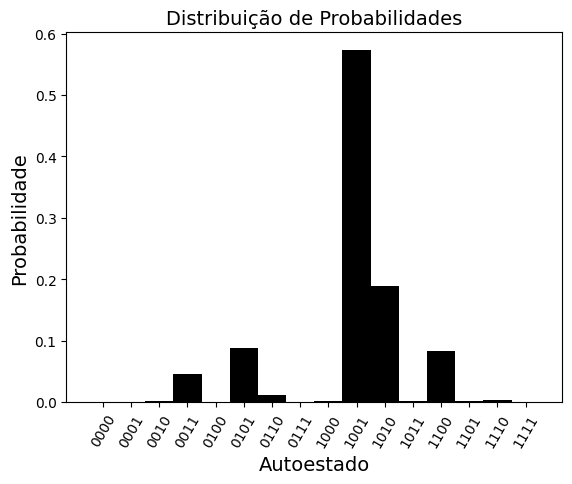

In [11]:
# Plot da distribuição de probabilidades
strings = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111',
           '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
width = 1
plt.bar(strings, probs, width=width, color='black')
plt.xlabel('Autoestado',    size=14)
plt.ylabel('Probabilidade', size=14)
plt.title('Distribuição de Probabilidades', size=14)
plt.xticks(strings, strings, rotation=60)

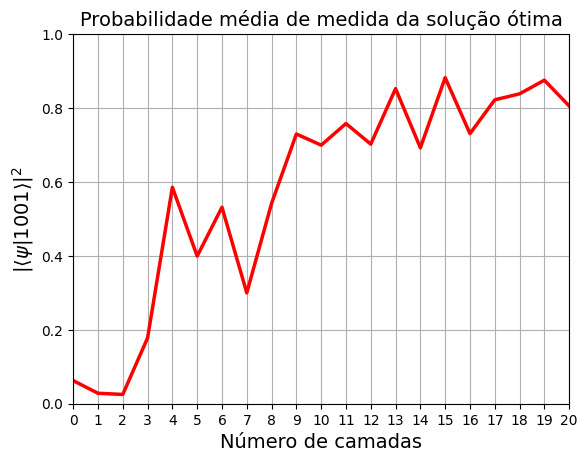

In [12]:
plt.xticks(range(len(prob1001_med)))
plt.plot(range(len(prob1001_med)), prob1001_med, 'r-', linewidth=2.5)
plt.title("Probabilidade média de medida da solução ótima", size=14)
plt.ylabel(r'$|\langle\psi|1001\rangle|^2$', size=14)
plt.xlabel("Número de camadas", size=14)
plt.axis([0, 20, 0, 1])
plt.grid(True)

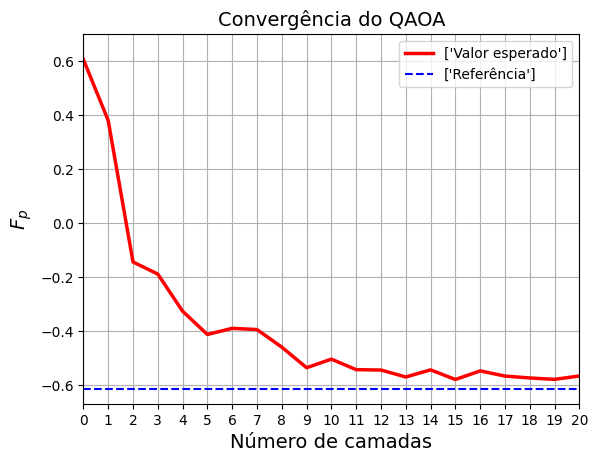

In [13]:
plt.xticks(range(len(Hmin_med)))
plt.plot(range(len(Hmin_med)), Hmin_med, 'r-', linewidth=2.5)
plt.plot(range(len(Hmin_med)), energy(
    [1, 0, 0, 1])*np.ones(len(Hmin_med)), 'b--', linewidth=1.5)
plt.legend([["Valor esperado"], ["Referência"]])
# plt.scatter(range(len(Hmin_avg)), Hmin_avg, color='red')
plt.title("Convergência do QAOA", size=14)
plt.ylabel(r'$F_p$', size=14)
plt.xlabel("Número de camadas", size=14)
plt.axis([0, 20, -0.67, 0.70])
plt.grid(True)

In [14]:
print(Hmin_med)


[0.6061766065486496, 0.37973503509978845, -0.1445687477661215, -0.18939008275971894, -0.3271547465692969, -0.4132261050251656, -0.39057502189019927, -0.39512786115119003, -0.4603226345199307, -0.5365427448846533, -0.5046984430591981, -0.5437830418904702, -0.545018530210337, -0.5709202910250359, -0.5444432102658688, -0.5802071127867794, -0.5483578422623947, -0.5674885996728573, -0.5745128607371245, -0.5797324801353188, -0.5670917696766405]


In [15]:
print(prob1001_med)


[0.06249999999999996, 0.02833326205329886, 0.02513358576973863, 0.177974714864699, 0.5855762317774542, 0.39940019185118114, 0.531626733856463, 0.29992095190794177, 0.5419525596591452, 0.7297557683493909, 0.6995915690792173, 0.7580176235091709, 0.7023570734491353, 0.8525244938151748, 0.6924116992276148, 0.8821262661319373, 0.7307450581103193, 0.8222441191500047, 0.8384600609429178, 0.8753505845558897, 0.8056325424015234]


# Notas sobre o QAOA

O QAOA é um algoritmo variacional da computação quântica, desenvolvido por Faihi em 2014, adequado para resolver problemas de otimização combinatória. Nesta seção, apresentaremos um problema de otimização combinatória que pode ser modelado como um modelo ferromagnético popular na mecânica estatística: o \textit{Modelo de Ising} (ou \textit{Hamiltoniano de Ising}). O algoritmo consiste em modelar a função objetivo (F.O.) como um \textit{Hamiltoniano de Ising} e transformá-la em operadores unitários, aplicar tais operadores em um estado de entrada, medir os valores esperados, atualizar os parâmetros e repetir o processo até que a função custo seja minimizada. Quando a energia da F.O. é minimizada, a distribuição de probabilidades (obtida após a medição da função de onda $|\psi\rangle$ com os parâmetros ótimos) apresenta uma ocorrência maior do autoestado de $|\psi\rangle$ que fornece a melhor configuração para o problema. 

### Modelo de Ising

O modelo do comportamento de materiais ferromagnéticos pode ser descrito pelo \textit{Hamiltoniano de Ising}. O modelo representa uma cadeia de partículas de spin 1/2, que interagem em pares, sendo que cada constituinte está sujeito à um campo magnético de magnitude $h_i$. Como partículas de spin 1/2 podem assumir apenas duas direções de momento de dipolo ("up" e "down") a interação entre cada par de partículas fornece uma energia (positiva ou negativa) de acordo com as orientações dos spins. Para encontrar a configuração dos momentos de dipolo que fornece o menor valor de energia possível do sistema, a seguinte função objetivo deve ser minimizada: 

\begin{equation} 
    C(z) = - \sum_{<ij>}^{}z_iz_j - \sum_{i}^{}h_iz_i .
\end{equation} 

As variáveis $z_i$ da função objetivo podem assumir apenas valores unitários, sejam eles positivos ou negativos, ou seja, $z_i \in \{-1,+1\}$. As variáveis podem ser escritas como operadores de Pauli-Z ($\sigma_z$), já que $\pm 1$ são autovalores de $\sigma_z$, associados às autofunções de spin das partículas.

### Operador de Fase

Para que seja possível mapear um problema de variáveis binárias $z_i$ para um problema de otimização de autovalores, uma estratégia é substituir as variáveis $z_i \in \{-1,+1\}$ por operadores unitários (que possuem autovalores $\lambda \in \{-1,+1\}$). Diante disso, é possível criar um Operador de Fase que representa as interações entre as partículas adjacentes, bem como a resposta das partículas ao campo magnético aplicado. Trata-se de escrever a função objetivo do problema como um operador unitário para que possa ser aplicada diretamente no circuito. Como visto, o operador descrito na Equação \ref{fo_ising} é não-unitário, visto que não satisfaz o critério da Equação 7. Contudo, cada termo da soma (negligenciando os coeficientes) é um operador unitário. Para descrever este Hamiltoniano define-se o Operador Gamma através da relação


\begin{equation} 
    U(C,\gamma)=e^{-i\gamma C(Z)}=e^{i\gamma\sum_{<ij>}^{}Z_iZ_j + i\gamma\sum_{i}^{}h_iZ_i} .
\end{equation}


Como $C(z)$ é expressa em termos dos operadores Pauli-Z e o produto tensorial entre eles geram matrizes diagonais, $U(C,\gamma)$ também é uma matriz diagonal (porém unitária), onde o parâmetro $\gamma$ é um dos parâmetros variacionais usados no QAOA. Desse modo, o operador $U(C,\gamma)$ pode ser escrito como a operação unitária

\begin{equation} 
    U(C,\gamma)=\prod_{<ij>}^{}e^{i\gamma Z_iZ_j}\prod_{i=0}^{N}e^{i\gamma h_iZ_i} .
\end{equation}

Esse operador (assim como produtos tensoriais entre matrizes de Pauli-Z) apresenta a forma de  uma matriz diagonal, onde os elementos da diagonal são exponenciais complexas que adicionam fases no estado quântico no qual é aplicado.

### Operador de Mistura

O operador $U(B,\beta)$ é aplicado com o objetivo de misturar as amplitudes (gerando interferências destrutivas e construtivas) possibilitando explorar melhor o espaço de busca e aumentando as chances de encontrar, com maior precisão, o ponto ótimo global da função objetivo. O Operador de Mistura pode ser descrito, matematicamente, como


\begin{equation} 
    U(B,\beta) = e^{-i\beta \sum_{j=0}^{N} X_j} \equiv \prod_{j=0}^{N}e^{-i\beta X_j}.
\end{equation}


Tal operador pode ser construído utilizando apenas operações de rotação em \textit{qubits} individuais do tipo RX. Contudo,a eficiência desse operador está diretamente ligada ao tempo de convergência e à acurácia do algoritmo. A Equação \ref{mix} descreve o operador em sua forma mais simples, representado apenas como rotações em torno do eixo $x$ da \textit{Esfera de Bloch}. 

### Função objetivo do QAOA: Medindo Valores Esperados
As operações unitárias apresentadas nas subseções anteriores podem ser representadas como diagramas de circuitos quânticos. No QAOA, cada conjunto das operações em questão são conhecidas como \textit{layers}. A $i$-ésima \textit{layer} do circuito pode ser escrita como


\begin{equation} 
    U(\gamma_i,\beta_i) = U(B,\beta_i)U(C,\gamma_i),
\end{equation}


e, portanto, a sequência desses operadores representa o operador geral do QAOA. Quanto maior o número de \textit{layers}, maior o número de parâmetros do circuito e, consequentemente, maior a acurácia do resultado. Assim como no VQE, a função objetivo do QAOA também é um valor esperado. A diferença entre eles é que, no VQE, utiliza-se um ansatz genérico e no QAOA, por sua vez, o ansatz é construído à partir da função objetivo. A atuação do operador geral do QAOA sobre o estado de entrada $|s\rangle$ pode ser considerada da seguinte maneira:
\begin{equation} 
    |\vec{\gamma},\vec{\beta} \rangle = (U(B,\beta_n)U(C,\gamma_n))...(U(B, \beta_1)U(C,\gamma_1))(U(B,\beta_0)U(C,\gamma_0))|s\rangle.
\end{equation}
Como é de interesse encontrar a configuração de menor energia para o hamiltoniano, a função objetivo do problema é, novamente, a função dos valores esperados de energia, que se minimizada, retorna o menor autovalor de energia do sistema. A função objetivo do problema pode ser expressa como

\begin{equation}
    \langle C(Z) \rangle \equiv \langle\vec{\gamma},\vec{\beta}|C(Z)|\vec{\gamma},\vec{\beta} \rangle.
\end{equation}
Como visto nos capitulos anteriores, o valor esperado de energia também pode ser escrito como um valor médio. Quando o estado quântico é preparado e medido uma quantidade suficiente de vezes, a distribuição de probabilidades obtida nos possibilita calcular o valor esperado como a soma da quantidade de vezes que cada autoestado da função de onda foi medido, multiplicada por suas respectivas energias associadas. Portanto, a função objetivo também pode ser escrita como
\begin{equation} 
    \langle\vec{\gamma},\vec{\beta}|C(Z)|\vec{\gamma},\vec{\beta} \rangle = E_0\alpha_0\langle\vec{\gamma},\vec{\beta}|0\rangle + E_1\alpha_1\langle\vec{\gamma},\vec{\beta}|1\rangle + E_2\alpha_2\langle\vec{\gamma},\vec{\beta}|2\rangle + ... + E_n\alpha_n\langle\vec{\gamma},\vec{\beta}|n\rangle =  \sum_{i=0}^{n}E_ip_i.
\end{equation}


Os parâmetros variacionais, $\gamma$ e $\beta$, são atualizados iterativamente através de métodos clássicos de otimização até que o menor autovalor de energia seja encontrado. Por se tratar de problemas de otimização combinatória, o interesse do problema é no autoestado da base computacional associado ao menor autovalor, que é composto pela \textit{bitstring} formada pela configuração ótima do problema. 


Como visto, o QAOA pode ser usado para encontrar a configuração que minimiza a energia do \textit{Hamiltoniano de Ising}. Por se tratar de um problema de otimização combinatória, percebe-se que o algoritmo é um bom candidato a resolver problemas dessa natureza. 

### O Método Variacional da Mecânica Quântica
Como discutido no Capítulo 2, informações sobre um estado quântico podem ser obtidas por meio de um conjunto de medidas sobre o sistema. Embora nosso objetivo seja encontrar o menor autovalor de uma matriz, a função objetivo do problema é calculada através valor esperado da matriz em questão, visto que se uma função de onda parametrizada por um conjunto de parâmetros $\theta$ é criada, o princípio variacional nos garante que
\begin{equation}
    \langle \mathcal{H}_\theta \rangle \equiv \langle \psi_\theta | \mathcal{H}|\psi_\theta \rangle \geq \lambda_{min}.
\end{equation}

Portanto, se o espaço de busca é suficientemente grande e o objetivo do problema é minimizar o valor esperado da matriz $ \mathcal{H}$, existe um conjunto de parâmetros $\theta'$ que minimiza a função objetivo. Diante disso, podemos afirmar que uma boa e confiável aproximação para o menor autovalor $\lambda{min}$ da matriz $\mathcal{H}$ pode ser dada por

\begin{equation}
    \langle \mathcal{H}_{\theta'}\rangle_{min} \approx \lambda_{min}.
\end{equation}

Uma explicação intuitiva do método variacional pode ser apresentada da seguinte maneira: O valor esperado (ou valor médio) de uma grandeza, pode assumir infinitos valores entre os respectivos máximo e mínimo. Logo, o valor médio de um observável físico nunca será menor que seu autovalor mínimo e nunca será maior que seu autovalor máximo. 
    
# Perspectivas
    
Futuros trabalhos nesta linha de pesquisa envolvem a inclusão de ruídos nas etapas quânticas da simulação. Esses ruídos ocorrem naturalmente nos computadores quânticos atuais e induzem erros que ainda não podem ser controlados eficientemente. Dessa forma, ao reproduzir os resultados com a inclusão de ruídos será possível determinar o ponto de transição onde os níveis de ruídos de um computador quântico passa a permitir a aplicação do  QAOA para a otimização de portfólios. 